In [1]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime

In [2]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [3]:
_C = CN()

_C.ROOT_PATH = ""
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 500
_C.IMAGE_H = 500
_C.MEAN = [0.4922, 0.4701, 0.4456]
_C.VAR = [0.2682, 0.2623, 0.2736]

In [4]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


In [5]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [6]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [7]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
       
        if self.transform:
            img = self.transform(img) 
            
        label = img_path.split('/')[1].split('_')
        return img, encode_label(label) 

A function, that lists all images contained in the folder.

In [8]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [9]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(_C.MEAN, _C.VAR)])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor(),
                       T.Normalize(_C.MEAN, _C.VAR)])

In [10]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

17192
4355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([0., 1., 0., 0.])


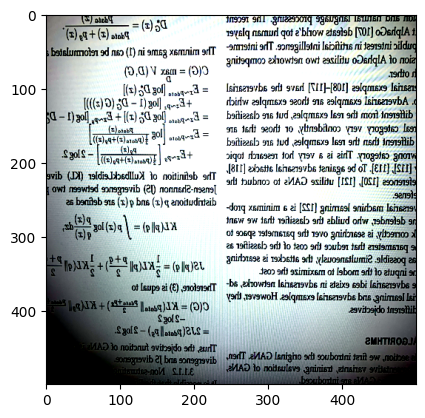

In [11]:
def show_example(img,label):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

show_example(*train_dataset[8000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([0., 0., 1., 0.])


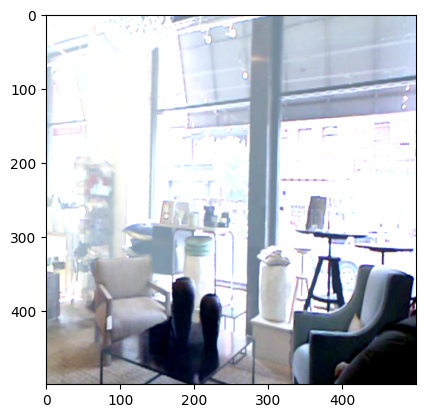

In [12]:
show_example(*val_dataset[2600])

In [13]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [14]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [15]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [16]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


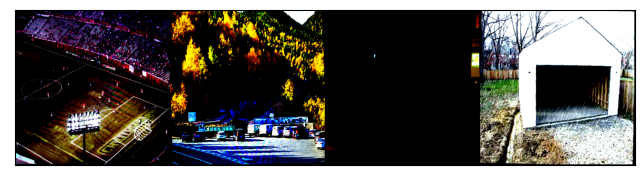

In [17]:
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [18]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [19]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [20]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [21]:
images, targets = next(iter(val_loader))
targets = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(0.3333), tensor(1.), tensor(0.5000))


In [22]:
def BCE_custom(preds, targets):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, target in enumerate(targets):
        for j, val in enumerate(target):
            if val == 0:
                losses[i][j] *= 0.5
    return losses.mean()

In [23]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets)   # Calculate loss
        del images
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [25]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [26]:
# checking up the shapes of the datas
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 500, 500])
torch.Size([4, 4])


In [27]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
        #input 3 x 500 x 500
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 500 x 500
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 500 x 500


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 120 x 120
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 120 x 120  


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 30 x 30
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 30 x 30


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 7 x 7
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 7 x 7


        self.classifier = nn.Sequential(nn.MaxPool2d(7), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 4    

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = torch.sigmoid(out)
        return out

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [29]:
class CustomModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=True)
        self.model.classifier = nn.Sequential(
          nn.Linear(1280, 512),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, 4)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        out = torch.sigmoid(out)
        return out

In [30]:
model = CustomModel().to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0
/home/berezerker/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


803908

In [31]:
#checking the shape of outputs that the model will produce before starting the training process
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 500, 500])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.4799, 0.4796, 0.4994, 0.5157],
        [0.4767, 0.4800, 0.5062, 0.5169]], device='cuda:0')


In [32]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(327155712, 12329984)

In [33]:
epochs = 10
max_lr = 0.001
grad_clip = 0.9
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [34]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.0, rec 0.0, f2 0.0
demoir
prec 0.0, rec 0.0, f2 0.0
haze
prec 0.27754629629629624, rec 0.9991666666666659, f2 0.434420289854732
rain
prec 0.23490241102181394, rec 0.999999999999999, f2 0.38043882484164043


[{'val_loss': 0.4318804144859314,
  'val_score': 0.341059094397099,
  'val_score_blur': 0.0,
  'val_score_haze': 0.434420289854732,
  'val_score_rain': 0.38043882484164043,
  'val_score_demoir': 0.0}]

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9108019639934527, rec 0.9832155477031794, f2 0.945624468988455
demoir
prec 0.8675438596491221, rec 0.988999999999999, f2 0.9242990654200619
haze
prec 0.9795751633986921, rec 0.9991666666666659, f2 0.9892739273922385
rain
prec 0.9999999999999988, rec 0.8504398826979463, f2 0.9191759112514832
Epoch [0], last_lr: 0.0003, train_loss: 0.2091, val_loss: 0.0564, val_score: 0.9468, val_score_blur: 0.9456, val_score_demoir: 0.9243, val_score_haze: 0.9893, val_score_rain: 0.9192


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.995178399228543, rec 0.9116607773851583, f2 0.951590594743622
demoir
prec 0.7320644216691063, rec 0.999999999999999, f2 0.8453085376157411
haze
prec 0.9933665008291866, rec 0.9983333333333326, f2 0.9958437240227744
rain
prec 0.9906542056074756, rec 0.9325513196480929, f2 0.9607250755282003
Epoch [1], last_lr: 0.0008, train_loss: 0.1306, val_loss: 0.0595, val_score: 0.9374, val_score_blur: 0.9516, val_score_demoir: 0.8453, val_score_haze: 0.9958, val_score_rain: 0.9607


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9415204678362566, rec 0.9955830388692571, f2 0.967797337912767
demoir
prec 0.9881593110871895, rec 0.917999999999999, f2 0.9517884914458448
haze
prec 0.9900908340214691, rec 0.9991666666666659, f2 0.9946080464532528
rain
prec 0.9321723189734181, rec 0.9941348973607028, f2 0.9621570482492632
Epoch [2], last_lr: 0.0010, train_loss: 0.1257, val_loss: 0.0256, val_score: 0.9703, val_score_blur: 0.9678, val_score_demoir: 0.9518, val_score_haze: 0.9946, val_score_rain: 0.9622


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9893522626441873, rec 0.9849823321554763, f2 0.9871624612655461
demoir
prec 0.9638671874999991, rec 0.986999999999999, f2 0.975296442687246
haze
prec 0.981996726677577, rec 0.9999999999999992, f2 0.9909165978525133
rain
prec 0.9845410628019315, rec 0.9960899315738015, f2 0.99028182701602
Epoch [3], last_lr: 0.0010, train_loss: 0.1136, val_loss: 0.0152, val_score: 0.9862, val_score_blur: 0.9872, val_score_demoir: 0.9753, val_score_haze: 0.9909, val_score_rain: 0.9903


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.990917347865576, rec 0.9637809187279144, f2 0.9771607702637177
demoir
prec 0.956777996070726, rec 0.973999999999999, f2 0.9653121902869123
haze
prec 0.9787928221859699, rec 0.9999999999999992, f2 0.9892827699912552
rain
prec 0.9433611884865358, rec 0.9931573802541535, f2 0.967619047618547
Epoch [4], last_lr: 0.0008, train_loss: 0.0990, val_loss: 0.0247, val_score: 0.9755, val_score_blur: 0.9772, val_score_demoir: 0.9653, val_score_haze: 0.9893, val_score_rain: 0.9676


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9840707964601761, rec 0.982332155477031, f2 0.9832007073381375
demoir
prec 0.9558117195004795, rec 0.994999999999999, f2 0.9750122488970984
haze
prec 0.9966777408637866, rec 0.9999999999999992, f2 0.9983361064886838
rain
prec 0.998019801980197, rec 0.9853372434017585, f2 0.9916379734377676
Epoch [5], last_lr: 0.0006, train_loss: 0.0926, val_loss: 0.0137, val_score: 0.9874, val_score_blur: 0.9832, val_score_demoir: 0.9750, val_score_haze: 0.9983, val_score_rain: 0.9916


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9937388193202139, rec 0.9814487632508826, f2 0.9875555555550547
demoir
prec 0.9659533073929952, rec 0.992999999999999, f2 0.9792899408279014
haze
prec 0.9966749792186194, rec 0.9991666666666659, f2 0.9979192675816881
rain
prec 0.9921951219512186, rec 0.9941348973607028, f2 0.993164062499499
Epoch [6], last_lr: 0.0004, train_loss: 0.0796, val_loss: 0.0130, val_score: 0.9898, val_score_blur: 0.9876, val_score_demoir: 0.9793, val_score_haze: 0.9979, val_score_rain: 0.9932


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9859154929577457, rec 0.9893992932862183, f2 0.9876543209871534
demoir
prec 0.9722497522299296, rec 0.980999999999999, f2 0.9766052762563432
haze
prec 0.9991659716430351, rec 0.9983333333333326, f2 0.9987494789490616
rain
prec 0.9778846153846146, rec 0.9941348973607028, f2 0.9859428017445306
Epoch [7], last_lr: 0.0002, train_loss: 0.0674, val_loss: 0.0122, val_score: 0.9878, val_score_blur: 0.9877, val_score_demoir: 0.9766, val_score_haze: 0.9987, val_score_rain: 0.9859


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9893333333333325, rec 0.9832155477031794, f2 0.9862649534775674
demoir
prec 0.9619512195121943, rec 0.985999999999999, f2 0.9738271604933263
haze
prec 0.9942004971002478, rec 0.9999999999999992, f2 0.9970918155375134
rain
prec 0.9921874999999991, rec 0.9931573802541535, f2 0.9926722032237296
Epoch [8], last_lr: 0.0000, train_loss: 0.0618, val_loss: 0.0131, val_score: 0.9879, val_score_blur: 0.9863, val_score_demoir: 0.9738, val_score_haze: 0.9971, val_score_rain: 0.9927


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9823943661971823, rec 0.9858657243816247, f2 0.9841269841264834
demoir
prec 0.9684729064039399, rec 0.982999999999999, f2 0.975682382133494
haze
prec 0.9975041597337763, rec 0.9991666666666659, f2 0.9983347210652777
rain
prec 0.9931506849315058, rec 0.9921798631476041, f2 0.9926650366743156
Epoch [9], last_lr: 0.0000, train_loss: 0.0567, val_loss: 0.0130, val_score: 0.9881, val_score_blur: 0.9841, val_score_demoir: 0.9757, val_score_haze: 0.9983, val_score_rain: 0.9927
CPU times: user 22min 55s, sys: 4min 10s, total: 27min 5s
Wall time: 37min 44s


In [86]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0003, train_loss: 0.0583, val_loss: 0.6194, val_score: 0.8376


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0008, train_loss: 0.0792, val_loss: 0.5038, val_score: 0.8391


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0010, train_loss: 0.0918, val_loss: 0.7018, val_score: 0.8361


  0%|          | 0/4298 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
evaluate(model, val_dl)

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9823943661971823, rec 0.9858657243816247, f2 0.9841269841264834
demoir
prec 0.9684729064039399, rec 0.982999999999999, f2 0.975682382133494
haze
prec 0.9975041597337763, rec 0.9991666666666659, f2 0.9983347210652777
rain
prec 0.9931506849315058, rec 0.9921798631476041, f2 0.9926650366743156


{'val_loss': 0.01296803168952465,
 'val_score': 0.988087056127793,
 'val_score_blur': 0.9841269841264834,
 'val_score_haze': 0.9983347210652777,
 'val_score_rain': 0.9926650366743156,
 'val_score_demoir': 0.975682382133494}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([2.6229e-05, 9.9998e-01, 2.5311e-07, 7.1551e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)


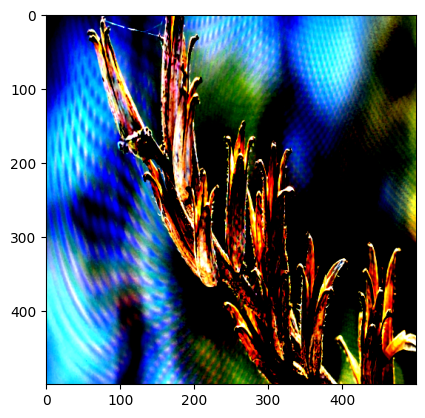

In [37]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_dataset[1500][0])

In [38]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

8
9
12
13
62
76
77
96
97
98
99
108
112
113
120
139
148
149
697
753
775
797
831
908
1215
1243
1276
1280
1289
1409
1456
1473
1550
1554
1610
1663
1703
1724
1855
1883
1937
1954
1955
2007
2043
2075
2091
2096
2769
3358
3380
3381
3393
3507
3509
3550
3635
3658
3793
4103
4259


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([5.0010e-08, 1.0000e+00, 3.9640e-12, 1.1733e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)


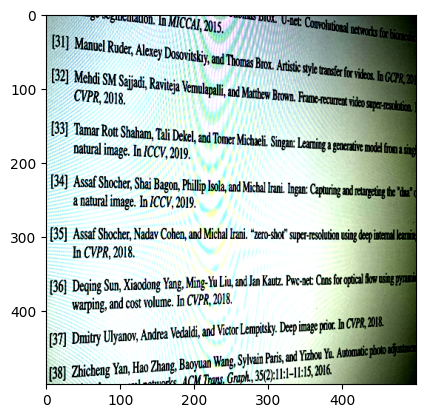

In [39]:
predict_single(val_dataset[1258][0])

In [40]:
val_dataset.im_path(1258)

'test/demoir/0126_moire.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([0., 1., 0., 0.])


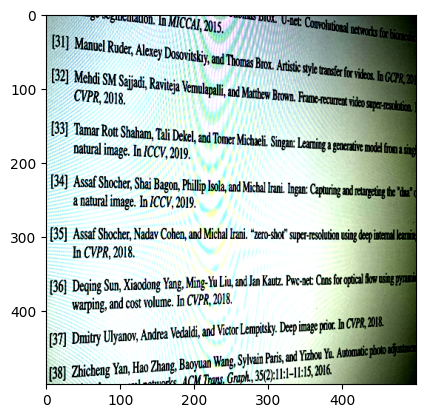

In [41]:
show_example(*val_dataset[1258])

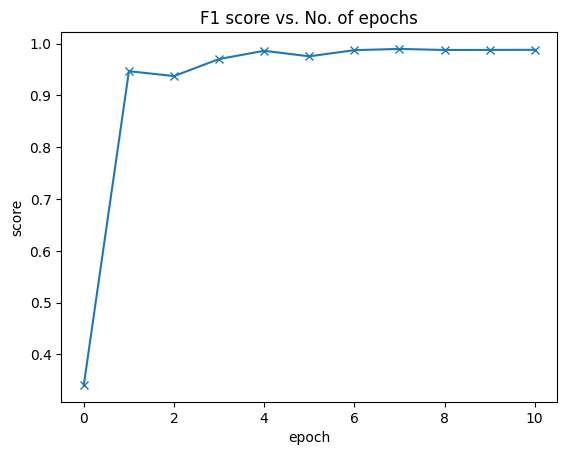

In [42]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

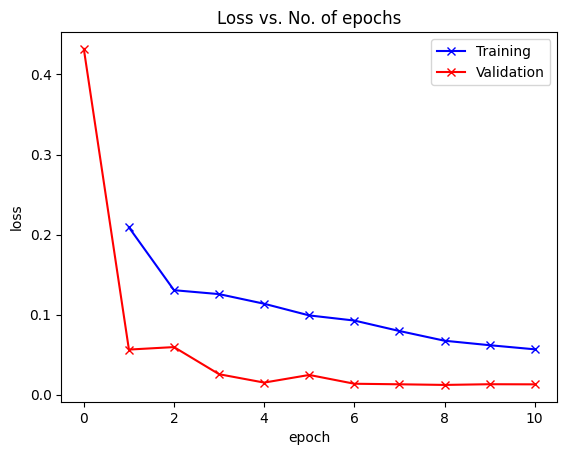

In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

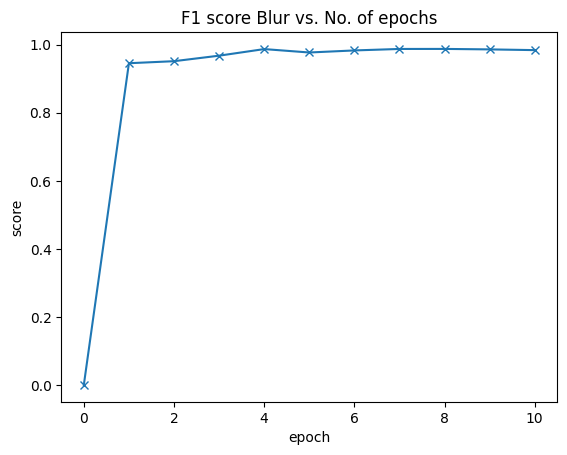

In [44]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

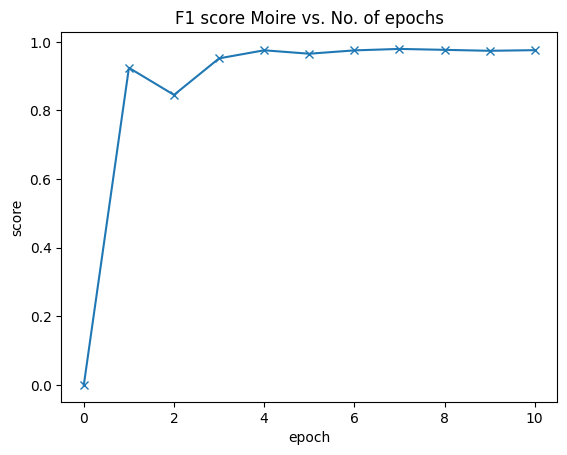

In [45]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

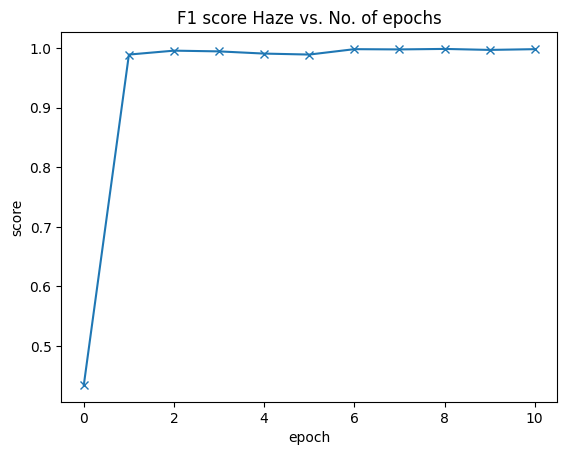

In [46]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

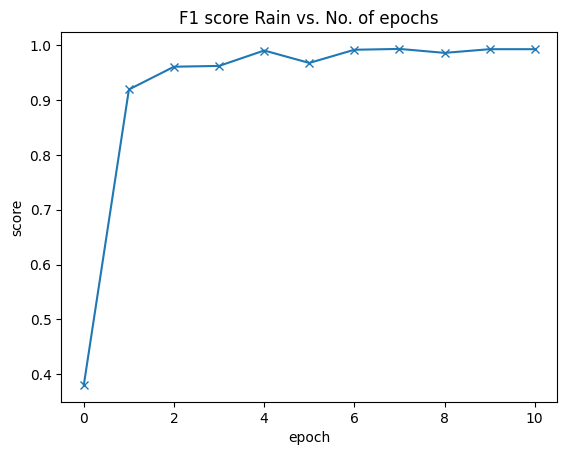

In [47]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

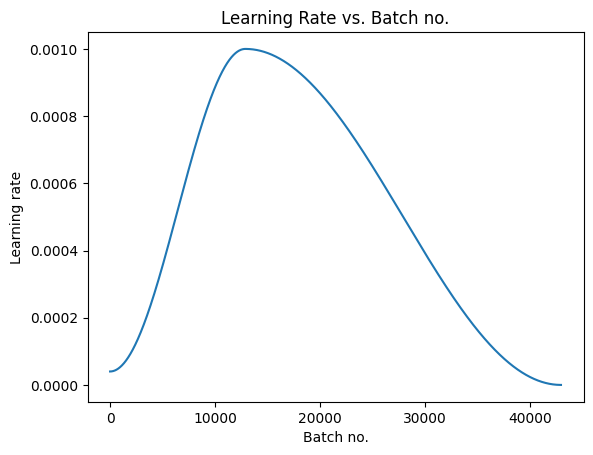

In [48]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [49]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([3.7508e-05, 2.0072e-05, 9.9996e-01, 7.3491e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: haze


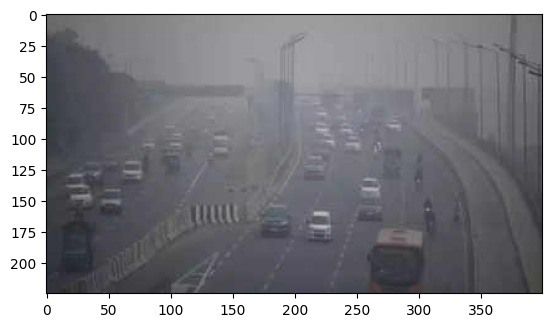

In [50]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([0.0340, 0.9725, 0.0067, 0.0330], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: demoir


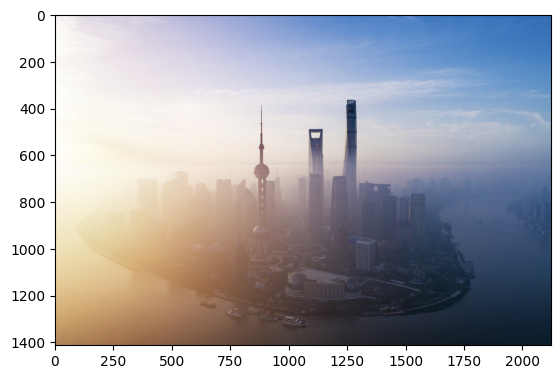

In [51]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([6.8950e-03, 3.1911e-02, 8.5937e-05, 9.8899e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: rain


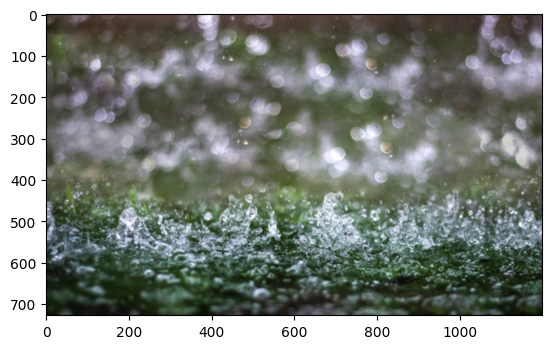

In [52]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([2.0033e-06, 1.0531e-06, 1.0000e+00, 6.0572e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)


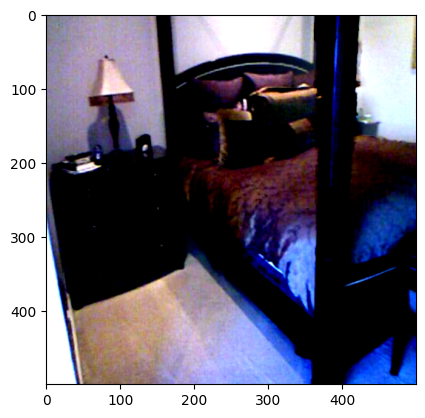

In [53]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_dataset[3280][0]) #checking out the predictions of some images from the validation dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([0., 0., 1., 0.])


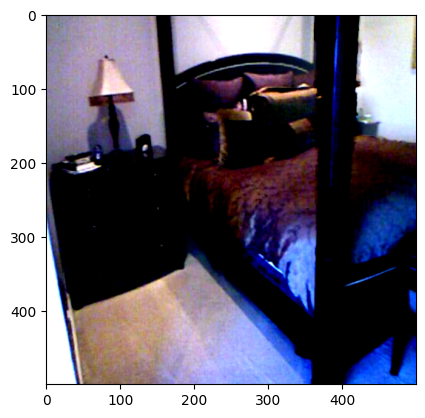

In [54]:
show_example(*val_dataset[3280]) #checking out the predictions of some images from the validation dataset.

In [55]:
PATH = os.path.join('saved_models', datetime.now().strftime('mobilenetv2_customBCE_new_metrics_13_05_23.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()

In [63]:
inp = torch.Tensor([[1,0,0,0], [1,1,0,1]])
tar = torch.Tensor([[1,0,1,0], [1,1,0,1]])

In [64]:
BCE_custom(inp, tar)

tensor(12.5000)

In [65]:
F.binary_cross_entropy(inp, tar)

tensor(12.5000)